In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from IPython.display import display
import scipy.special

## Noise Budget
Calculating the noise budget.

Reference: Cox, Charles Howard. Analog optical links: theory and practice. Cambridge University Press, 2006.
https://ebookcentral.proquest.com/lib/gwu/detail.action?docID=259853&pq-origsite=primo#

From 5.3.3 solid state CW laser with photodetector current < 100 mA, shot noise dominates over RIN.

5.18
$$
NF=10\log{\left(2+\frac{\left\langle i_{sn}^2\right\rangle R_{LOAD}}{g_ik_{b}T}\right)}
$$

Substituting gain ($g_i$) for MZI modulator:

5.19
$$
NF=10\log{\left(2+\frac{2qI_DR_{LOAD}}{\left(\frac{T_{Link}P_I\pi R_s}{2V_\pi}\ \right)^2r_d^2k_{b}T}\right)}
$$

where 
>$ T_{Link} = optial\ transmission\ through\ link = 1 - insertion\ loss\ ratio $

>$ R_{LOAD} = load\ resistance\ of\ detector $

>$ R_{S} = modulator\ resistance $ 

> $ P_I = input\ optical\ power $

> $ V_{\pi} = modulator\ voltage\ for\ 1\ \pi\ phase\ change$

> $ I_D = dark\ current$

> $ r_d = responsivity\ of\ detector $

> $ q = electron\ charge$

> $k_{b} = Boltzmann\ constant $

> $ T = temperature $

We can solve for input power in terms of a given NF:

$ P_I=\sqrt{\frac{2qI_DR_{LOAD}}{\left({10}^\frac{NF}{10}-2\right)\left(\frac{T_{Link}\pi R_s}{2V_\pi}\ \right)^2r_d^2k_{b}T}} $


In [2]:
def to_dB_P(x):
    return(10*sy.log(x, 10))
def from_dB_P(x):
    return(10**(x/10))
def to_dB_V(x):
    return(20*sy.log(x, 10))
def from_dB_V(x):
    return(10**(x/20))

# our losses in dB per wavelength through the PIC add together
loss_laser2WG,loss_WG,loss_MRR,loss_PCM,loss_EOM,loss_passives,loss_margin \
    = sy.symbols('loss_{laser2WG},loss_{WG},loss_{MRR},loss_{PCM},loss_{EOM},loss_{passives},loss_{margin}')
PIC_total_losses_per_lambda = loss_laser2WG + loss_WG + loss_MRR + loss_PCM + loss_EOM + loss_passives + loss_margin

T_Link,R_LOAD,R_S,NF,V_pi,I_D,r_d,q,k_b,T \
    = sy.symbols('T_{Link},R_{LOAD},R_{S},NF,V_{\pi},I_D,r_d,q,k_{b},T')

# our transmission through the link is the ratio of the losses
T_Link = from_dB_P(PIC_total_losses_per_lambda)

# optical input power in terms of NF and other parameters as shown in the markup above
P_I = sy.sqrt(2*q*I_D*R_LOAD/((10**(NF/10)-2)*(T_Link * sy.pi * R_S/(2*V_pi))**2 * r_d**2 * k_b * T))

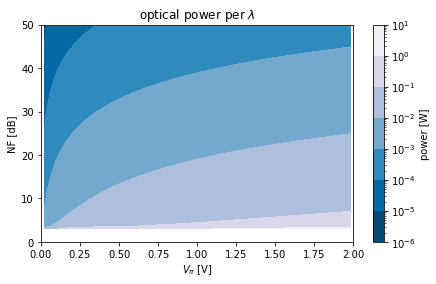

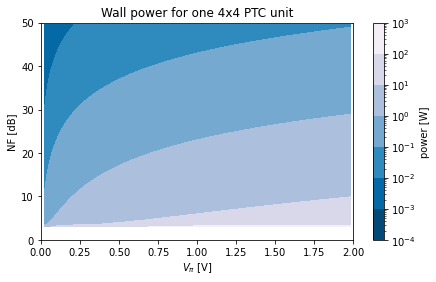

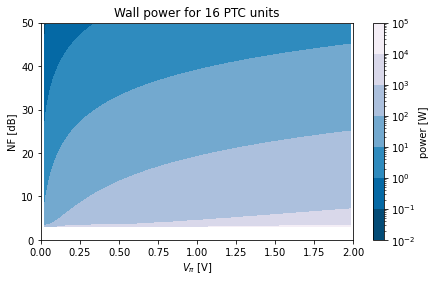

In [3]:
# losses of a single wavelength through the PIC

                                            # note:                                         ref.
PIC_loss_params = [(loss_laser2WG,-1.6),        # [dB] e.g. Photonic wire bonds 	            Lindemann et al. Opt. Exp.
                   (loss_WG,-2.5),              # [dB] say 10mm total PIC                       e.g. AIM PDK
                   (loss_MRR,-6),               # [dB] 2x times e.g.                            e.g. AIM PDK
                   (loss_PCM,-3),               # [dB] at 4 bit resolution                      Sorger Group, APR (2020)
                   (loss_EOM,-5),               # [dB] 
                   (loss_passives,-3),          # [dB] e.g. MUX
                   (loss_margin,-3.9)]          

# parameters of the modulator
modulator_params = [(R_S, 50)]    # [Ohm] resistance
                   # (V_pi, 0.71)] # [V] voltage to cross pi phase

# parameters of the detector
detector_params = [(I_D, 100e-9),  # [A] dark current
                   (R_LOAD, 50),   # [Ohm] load resistance
                   (r_d, 0.9)]     # [ratio] responsivity

# other model parameters
other_params = [(k_b, 1.380649e-23), # [J/K] Boltzmann constant
                (q, 1.60217646e-19), # [C] electron charge
                (T, 300)]            # [K] temperature

params = PIC_loss_params + modulator_params + detector_params + other_params
P_I_sub = P_I.subs(PIC_loss_params + modulator_params + detector_params + other_params)

# make a sweepable function of noise figure and V_pi
P_I_function_of_NF_V_pi = sy.lambdify([V_pi, NF], P_I_sub)

V_pi_sweep = np.linspace(0,2,100)
NF_sweep = np.linspace(0,50,100) 
X,Y = np.meshgrid(V_pi_sweep, NF_sweep) 
Z = np.zeros(np.shape(X))

for x in range(0,len(V_pi_sweep)-1):
    for y in range(0,len(NF_sweep)-1):
        Z[x,y] = P_I_function_of_NF_V_pi(X[x,y], Y[x,y])

plt.figure(figsize=(7,4))
plt.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r) 
plt.xlabel('$V_{\pi}$ [V]')
plt.ylabel('NF [dB]')
plt.colorbar(label='power [W]')
plt.title('optical power per $\lambda$')
plt.show()

wall_plug_efficiency = 0.1
plt.figure(figsize=(7,4))
plt.contourf(X, Y, (1/wall_plug_efficiency)*16*Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r) 
plt.xlabel('$V_{\pi}$ [V]')
plt.ylabel('NF [dB]')
plt.colorbar(label='power [W]')
plt.title('Wall power for one 4x4 PTC unit')
plt.show()

plt.figure(figsize=(7,4))
plt.contourf(X, Y, (1/wall_plug_efficiency)*64*16*Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r) 
plt.xlabel('$V_{\pi}$ [V]')
plt.ylabel('NF [dB]')
plt.colorbar(label='power [W]')
plt.title('Wall power for 16 PTC units')
plt.show()

